# Compare empirical vs. simulation rainfall C.V.

Originally, I plotted up the distributions of 10,000 simulations vs. 80 years of data so we had a sample size problem. Below, I compare rainfall from empirical data vs. simulation data with comparable sample sizes by resampling the simulation data. The end goal is to see whether the C.V.s of the two sources of rainfall data are similar.

Different things we can try:
- [Full years worth of rainfall](#365_OlJogi)
- OND months
- [MAM months](#MAM_Jacobson)
- Growing season (6 months)
- 2 different stations

Do this all for average conditions. Could also break up by three eras.

In [1]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

### Functions

Import empirical rainfall data

In [17]:
def grab_rf_data(station=None, data_file=None):
    """ Grabs the rainfall data from the CETRAD data file for a specific station.
    
    Usage:
        grab_rf_data(station, data_file)
        
        station = 'Jacobson Farm' # string
        data_file = "../data/CETRAD/CETRAD_rainfall.csv" # path_to_file
        
    Note: This will only work for Laikipia stations
    """
    station=station
    data_file=data_file

    # Prepare the CETRAD dataset.
    df = pd.read_csv(data_file)  # Read in the raw csv data.

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y' # Column RDate has data in M/D/YY
    df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

    # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
    # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
    # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]
    df['Week'] = [dt.week for dt in df['Datetime']]
    df['Dekad'] = df['Datetime'].dt.dayofyear//10+1

    n_years = len(df['Year'].unique())

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

    # Step 5.  Delete the old RDate column, which we no longer need. 
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)

    columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Datetime']
    rainfall = df[columns]
    return rainfall.dropna()

## How do simulated totals for MAM compare to empirical values? <a id='MAM_Jacobson'></a>

We'll start with Jacobson Farm (80 years worth of data) for MAM season.

In [3]:
# Import some data rather than re-running

# MAM rainfall data from Jacobson Farm
rf_mam = pd.read_csv('../output/3-cv-translation/rf_empirical.csv',sep=',').set_index('Year'); rf_mam

# MAM rainfall totals from three eras, including average - These looks like yearly totals, not seasonal....
r0 = pd.read_csv('../output/3-cv-translation/rf_sims_1930s.csv',sep=',').drop(['Unnamed: 0'], axis=1); r0
r1 = pd.read_csv('../output/3-cv-translation/rf_sims_avg.csv',sep=',').drop(['Unnamed: 0'], axis=1)
r2 = pd.read_csv('../output/3-cv-translation/rf_sims_2010s.csv',sep=',').drop(['Unnamed: 0'], axis=1)

,Source,Rainfall Era,Average,Standard Deviation,No. in Sample
0,Simulations,1930s,232.169060,44.449290,10000
1,Simulations,Avg.,260.716336,59.558915,10000
2,Simulations,2010s,238.658933,66.929297,10000
3,Empirical,1934-1973,262.317500,81.731392,40
4,Empirical,Avg.,260.289855,88.408690,81
5,Empirical,1975-2014,258.811956,96.613365,40


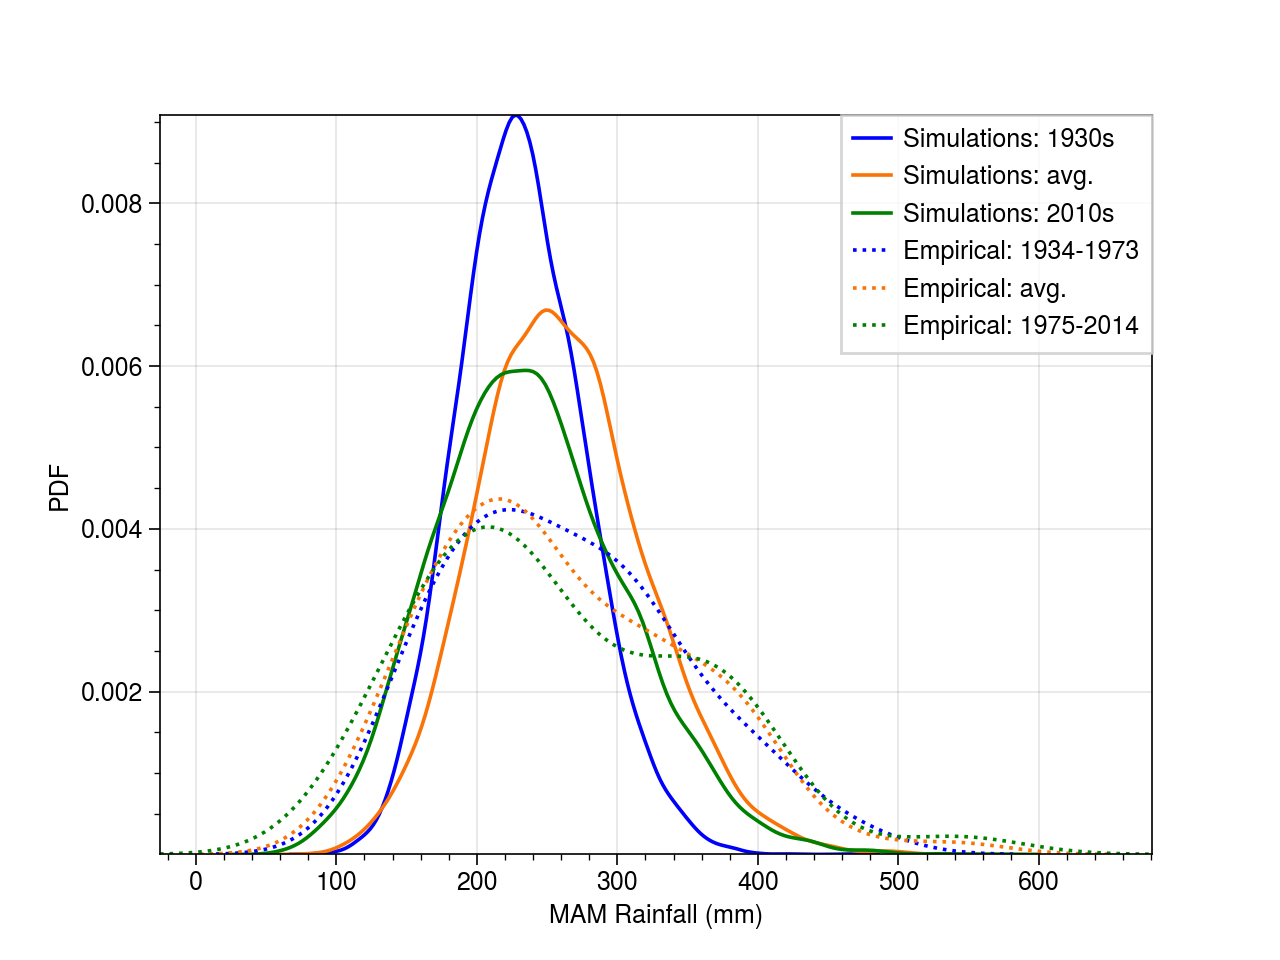

In [10]:
def seasonal_rf(station = None, data_file = None, months = None, xlab = None):
    """ Takes simulation data and empirical data and compares the distributions of MAM seasonal rainfall.
    Returns a plot. 
    
    Usage:
        seasonal_rf(rf, months, xlab)
        
        rf = rf # DataFrame of daily rainfall 
        months = ['3','4','5'] # List of months to subset
        xlab = 'MAM Rainfall (mm)' # String for x-axis label
        
    """
    rf = grab_rf_data(station=station, data_file=data_file)
    rf_ = rf.loc[rf['Month'].isin(months)]
    rf_ = rf_.groupby(['Year'])[station].sum().to_frame()

    # Then seperate into first 40 years, last 40 years
    len(rf_[rf_.index > 1974]) # 40
    len(rf_[rf_.index < 1974]) # 40

    # Distributions of MAM rainfall
    # Plot simulation data
    sns.kdeplot(r0['mam_RF'], color='blue',label="Simulations: 1930s") # can change bandwith to see how tightly estimation fits the data
    sns.kdeplot(r1['mam_RF'], color='orange',label="Simulations: avg.") # bw=.2
    sns.kdeplot(r2['mam_RF'], color='green', label="Simulations: 2010s")
    # Plot empirical data, note: This creates the same plot as using rf_mam. Best to stick with one probably.
    sns.kdeplot(rf_[rf_.index < 1974][station], color='blue',label="Empirical: 1934-1973", linestyle=":") # bw=.2
    sns.kdeplot(rf_[station], label="Empirical: avg.", color='orange',linestyle=":") # can change bandwith to see how tightly estimation fits the data
    sns.kdeplot(rf_[rf_.index > 1974][station], color='green',label="Empirical: 1975-2014", linestyle=":")
    
    plt.legend();
    plt.ylabel('PDF')
    plt.xlabel(xlab)
    
seasonal_rf(station='JACOBSON FARM', data_file = "../data/CETRAD/CETRAD_rainfall.csv", months = ['3','4','5'], xlab='MAM Rainfall (mm)')

# Table of means

table = pd.DataFrame({
                   # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
            'Source':['Simulations','Simulations','Simulations','Empirical','Empirical','Empirical'],
        'Rainfall Era':['1930s','Avg.','2010s',
                        '1934-1973','Avg.','1975-2014'],
            'Average':[r0['mam_RF'].mean(),r1['mam_RF'].mean(),r2['mam_RF'].mean(),
                       rf_mam[rf_mam.index < 1974]['JACOBSON FARM'].mean(),
                       rf_mam['JACOBSON FARM'].mean(),
                       rf_mam[rf_mam.index > 1974]['JACOBSON FARM'].mean()],
            'Standard Deviation':[r0['mam_RF'].std(),r1['mam_RF'].std(),r2['mam_RF'].std(),
                       rf_mam[rf_mam.index < 1974]['JACOBSON FARM'].std(),rf_mam['JACOBSON FARM'].std(),
                       rf_mam[rf_mam.index > 1974]['JACOBSON FARM'].std()],
            'No. in Sample':[len(r0['mam_RF']),len(r1['mam_RF']),len(r2['mam_RF']),
                       len(rf_mam[rf_mam.index < 1974]['JACOBSON FARM']) ,
                       len(rf_mam['JACOBSON FARM']),
                       len(rf_mam[rf_mam.index > 1974]['JACOBSON FARM'])]})

table

For simplicity, let's just look at the average simulation for MAM (orange line) against average empirical MAM (dotted line). Sample size will still be off:

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Source,Average,Standard Deviation,CV,No. in Sample
0,Simulations,260.716336,59.558915,0.228443,10000
1,Empirical,260.289855,88.408690,0.339655,81


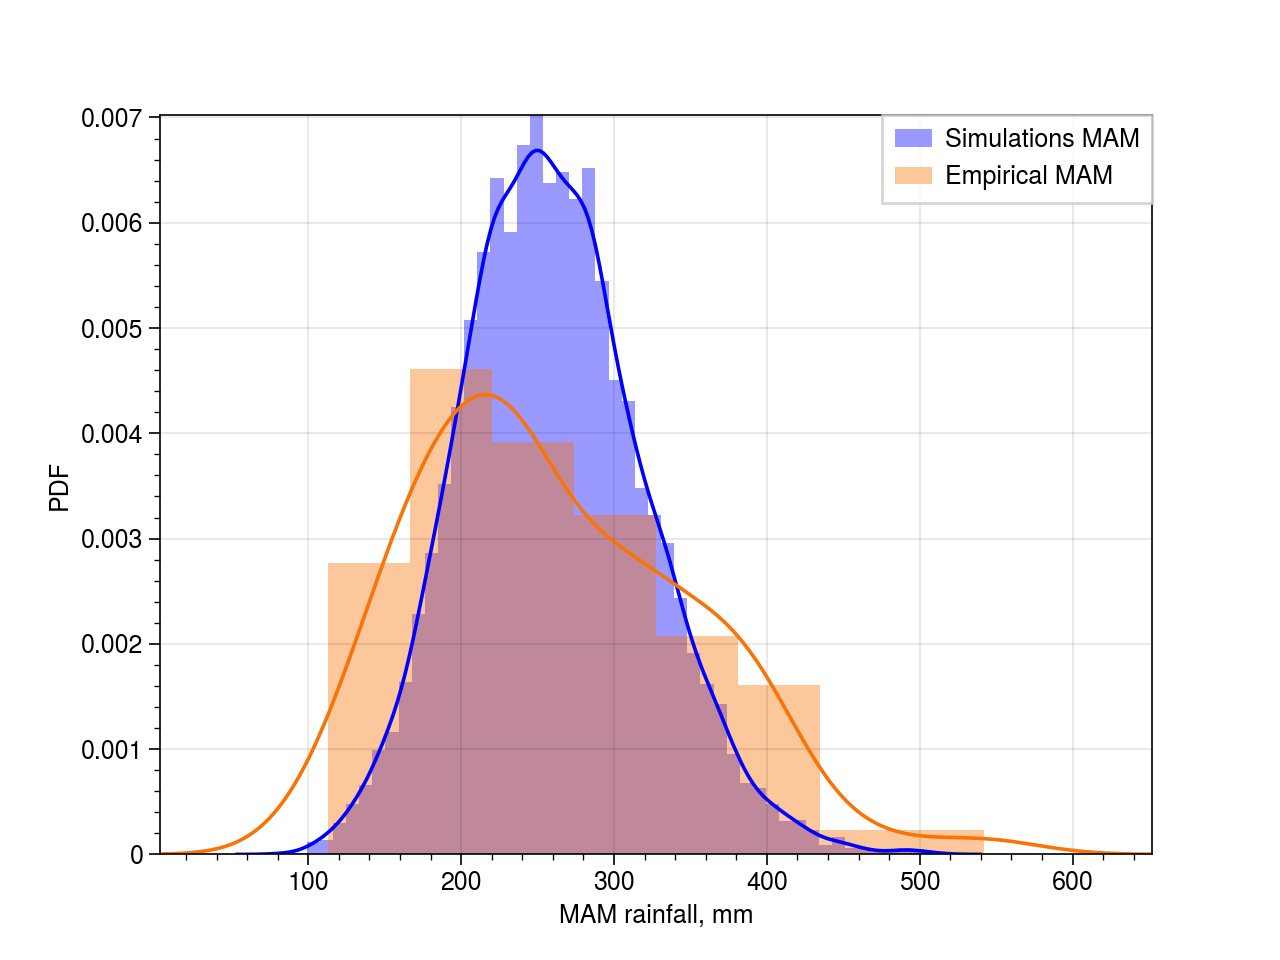

In [11]:
sns.distplot(r1['mam_RF'], color='blue', label="Simulations MAM") 
sns.distplot(rf_mam['JACOBSON FARM'], color='orange', label="Empirical MAM") 
plt.ylabel('PDF')
plt.xlabel('MAM rainfall, mm')
plt.legend();

table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[r1['mam_RF'].mean(), rf_mam['JACOBSON FARM'].mean()],
            'Standard Deviation':[r1['mam_RF'].std(),
                       rf_mam['JACOBSON FARM'].std()],
            'CV':[r1['mam_RF'].std()/r1['mam_RF'].mean(),
                       rf_mam['JACOBSON FARM'].std()/rf_mam['JACOBSON FARM'].mean()],
            'No. in Sample':[len(r1['mam_RF']),
                       len(rf_mam['JACOBSON FARM'])]})

table

We need to sample 80 seasons from 10,000 seasons to get one realization of the model data that can be compared with the empirical data.

Let's check the length the Jacobson Farm data and set this as a variable for the number of years we want to sample from the simulations data:

In [8]:
n_sample = len(rf_mam); print(n_sample)

81


In [34]:
# Let's take a sample of `n_sample` size from the simulation data
samp = r1.RF.sample(n=n_sample).values

# Then compare the coefficient of variation between the two
print('this is the C.V. of the model output',samp.std()/samp.mean())

print('this is the C.V. of the empirical data',rf_mam['JACOBSON FARM'].std()/rf_mam['JACOBSON FARM'].mean())

this is the C.V. of the model output 0.15220238733347433
this is the C.V. of the empirical data 0.3396547689121328


In [10]:
# Run thise 1k times and see if the values converge

# should be able to do this in in a list comprehension
n = 1000
sigma = r1.RF.sample(n=n_sample).std()
mu = r1.RF.sample(n=n_sample).mean()

cvs = [r1.RF.sample(n=n_sample).std()
       /r1.RF.sample(n=n_sample).mean() for n in range(n)]

What we want to know: Given the sample variability in C.V. (0.10 to 0.24) from the simulations, is it close enough to the C.V. we from the empirical data?

,0
count,1000.000000
mean,0.322403
std,0.045602
min,0.183805
25%,0.290426
50%,0.318658
75%,0.352975
max,0.493007


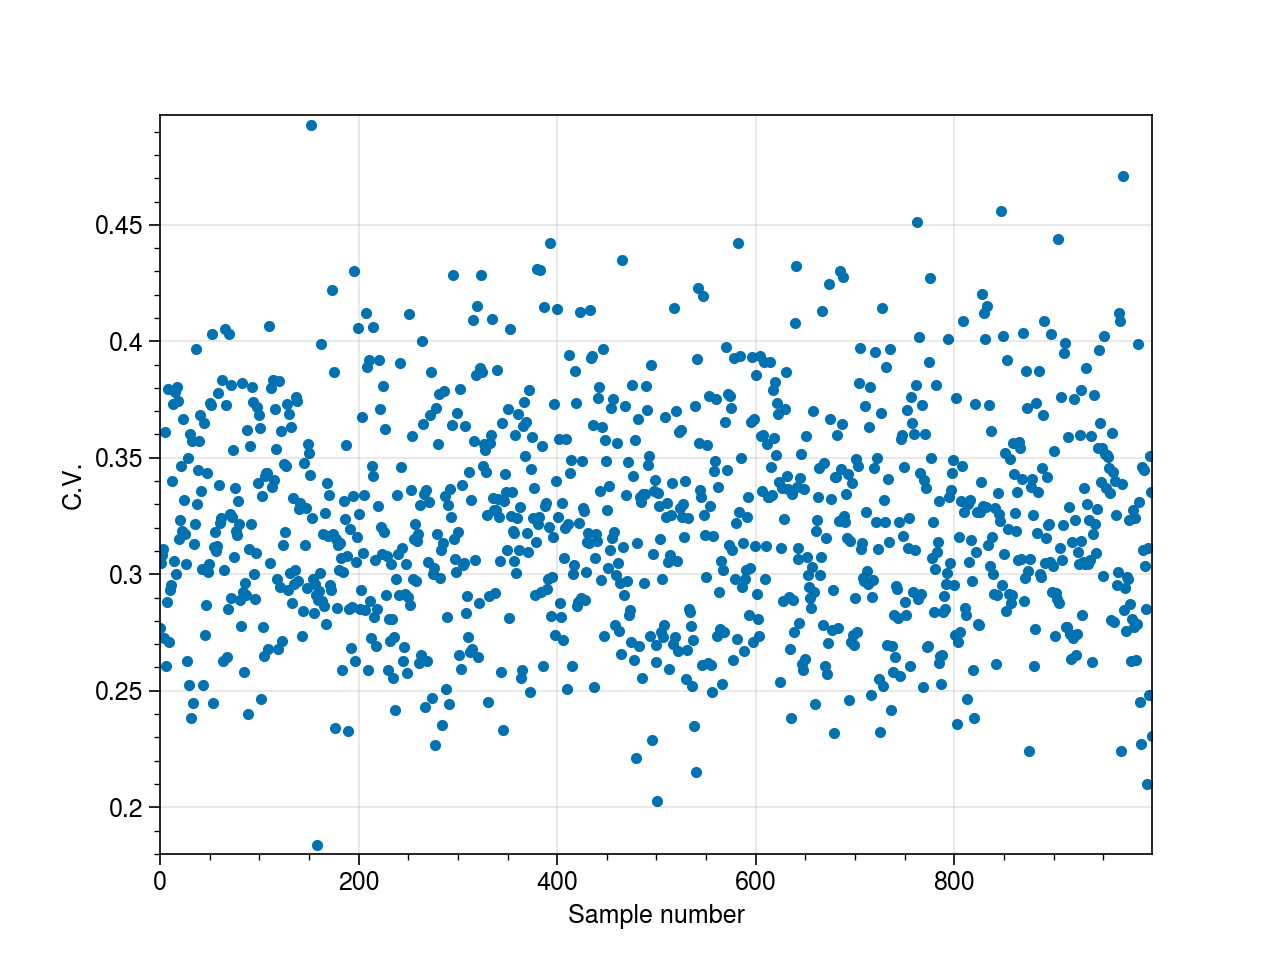

In [12]:
def plot_cvs(cvs = None, ylabel='C.V.', xlabel='Sample number'):
    plt.scatter(np.arange(0, n), np.sort(cvs))
    #plt.plot(np.sort(cvs))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return pd.DataFrame(cvs).describe()
    
plot_cvs(cvs=cvs)

## That's the situation for MAM. What if we try OND?

Did not do this because need simulation results for OND.

In [12]:
#seasonal_rf(rf=rf, months = ['10','11','12'], xlab='OND Rainfall (mm)')


## Annual rainfall for Jacobson Farm

In [18]:
# Import in the data
n_sim = 10000
no_sims = np.arange(0,n_sim)

#files = glob.glob('../output/final/full_year/*.csv') # old lambdas
files = glob.glob('../output/new_lambdas_jacobson_farm/*.csv') # new lambdas

output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]
len(output) # Check that there are 10,000 seasons

10000

In [19]:
output_rf = np.array([df['R'].sum() for df in output])

# So this is the annual rainfall for 10,000 simulations. Normal or "average" dekad and lambda values.

sims_rf = output_rf

### Let's get annual rainfall for Jacobson Farm (empirical)

In [21]:
# Let's get annual rainfall from empirical data
rf = grab_rf_data(station='JACOBSON FARM', data_file="../data/CETRAD/CETRAD_rainfall.csv")
rf_OlJogi = rf.groupby(['Year'])['JACOBSON FARM'].sum().to_frame()

# Some of these look like they may have incomplete records

In [42]:
emp_rf = rf_OlJogi['JACOBSON FARM'].values

print('heres the simulation rainfall for JF', sims_rf)
print('heres the empirical rainfall for JF', emp_rf) # that last value doesnt seem right 

emp_rf = emp_rf[:-1] # if going to remove this need to do it sooner becaause rainfall lambdas is based on this

heres the simulation rainfall for JF [610.33661419 761.76571839 834.71303757 ... 741.64137816 627.58904594
 678.59360527]
heres the empirical rainfall for JF [ 419.9       773.7       895.1       748.7       694.2       518.
  744.        757.9       690.6       584.6       661.7       555.3
  442.1       832.4       779.3       645.1       661.9      1047.4
  672.9       637.7       835.9       828.9       855.2       771.1
  840.2       687.9       715.6      1144.6       799.6      1066.8
  961.1       503.        760.3       720.1       985.9       829.6
  526.1       718.7       589.2       514.1       701.2       781.1
  742.9       860.2       730.5       811.4       474.2       768.4
  587.4       804.        483.1       692.1       803.2       710.3
  825.9       912.4       860.7       609.3       604.1       693.5
  858.5       967.        696.722    1165.606     768.858     615.188
  464.3628    757.428     967.428     845.3       733.        685.00007
  767.000066  800.000

We want to compare the same number of values for th empirical and simulation data. Currently the sample sizes are very different:

In [43]:
print(len(sims_rf), len(emp_rf))

10000 81


So we need to sample 33 values from the simulation data. Calculate C.V. and then run this 1k times and see if the values converge

,0
count,1000.000000
mean,0.223789
std,0.018436
min,0.160650
25%,0.211979
50%,0.223162
75%,0.236132
max,0.298623


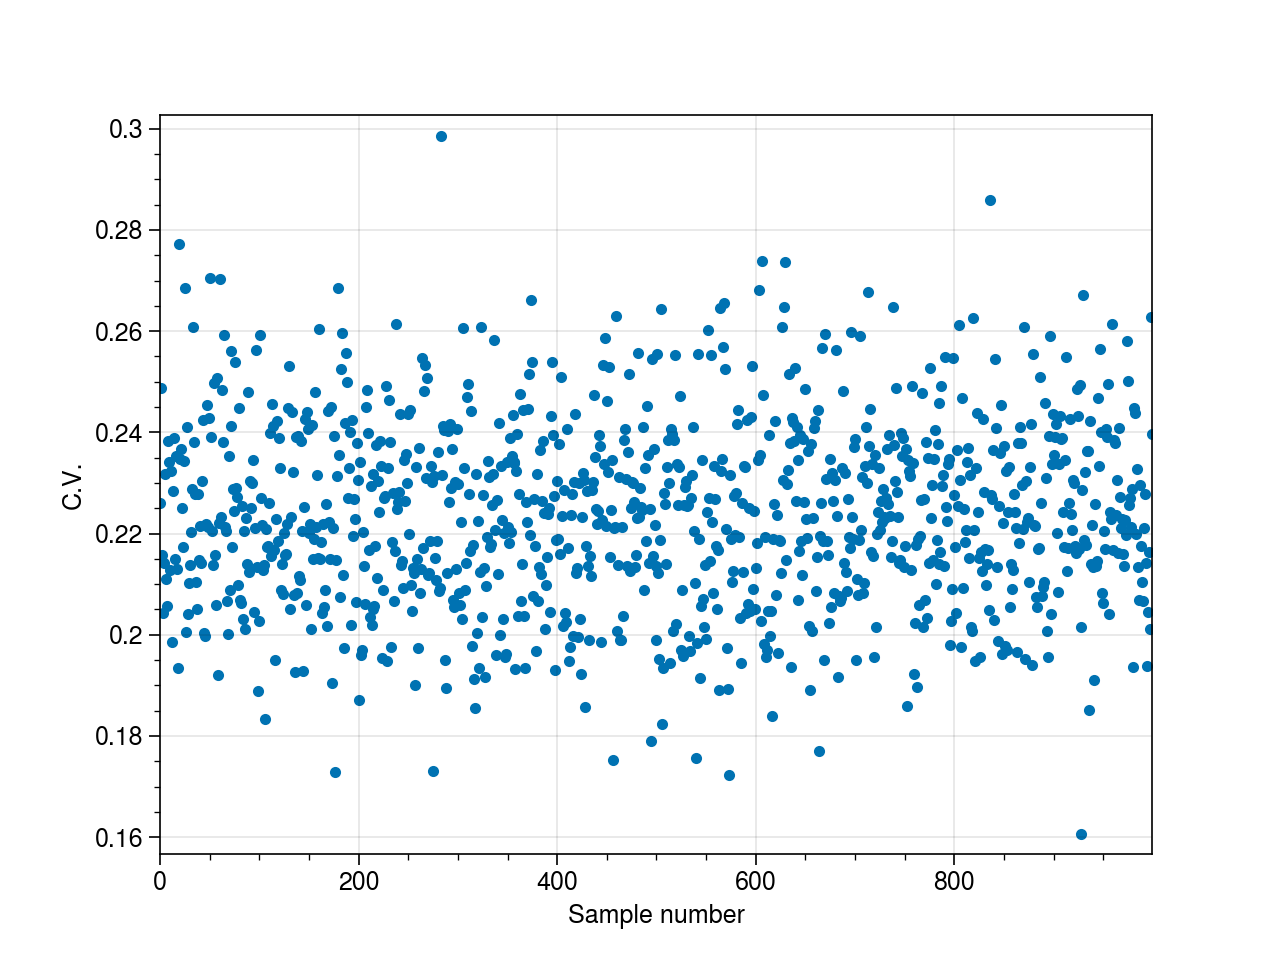

In [44]:
n = 1000
n_sample = len(emp_rf)

# Let's see how this works to get 33 samples from simulation data
samp_rf = pd.DataFrame(sims_rf).sample(n=n_sample)
#print(samp_rf)

# Get C.V.s of sampled simulation data
cvs = [pd.DataFrame(sims_rf).sample(n=n_sample).std()
       /pd.DataFrame(sims_rf).sample(n=n_sample).mean() for n in range(n)]

plt.xlabel('Sample number')
plt.ylabel('C.V.')
pd.DataFrame(cvs).describe()

plot_cvs(cvs=cvs)

Here are the statistics for all of the samples:

In [45]:
# Make a table comparing the CVs of the sampled values compared to the empirical
table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[sims_rf.mean(), emp_rf.mean()],
            'Standard Deviation':[sims_rf.std(), emp_rf.std()],
            'CV':[sims_rf.std()/sims_rf.mean(), emp_rf.std()/emp_rf.mean()],
            'No. in Sample':[len(sims_rf),
                       len(emp_rf)]})

table

,Source,Average,Standard Deviation,CV,No. in Sample
0,Simulations,666.973287,149.216021,0.223721,10000
1,Empirical,744.008562,154.002541,0.206990,81


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


81 81


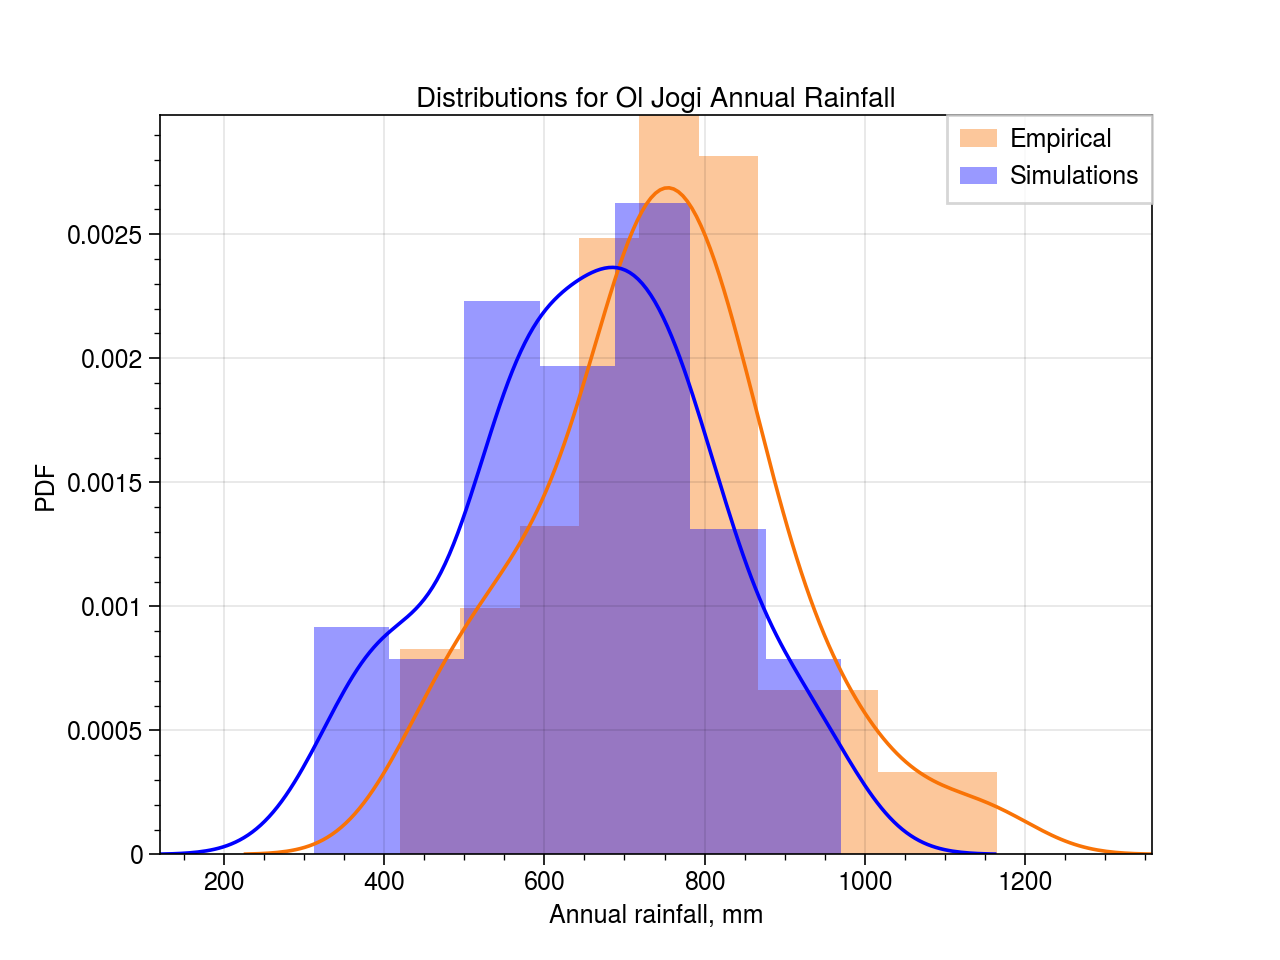

In [46]:
# Let's plot the sampled rainfall (from simulations) versus the empirical

# Get the n values
#sns.displot(samp_rf[0], label="Simulations") # "avg" # bw=.2
#sns.kdeplot(emp_rf, label="Empirical", cut=0) # clip=(0,1000
sns.distplot(emp_rf, label="Empirical", color='orange', bins=10)
sns.distplot(samp_rf[0], label="Simulations", color='blue')

plt.title('Distributions for Ol Jogi Annual Rainfall')
plt.ylabel('PDF')
plt.xlabel('Annual rainfall, mm')
plt.legend();

print(len(emp_rf), len(samp_rf[0]))

## Next, let's do a full years worth of rainfall for Ol Jogi Farm <a id='365_OlJogi'></a>

### Import simulation rainfall data

In [4]:
# Import in the data
n_sim = 10000
no_sims = np.arange(0,n_sim)

#files = glob.glob('../output/final/full_year/*.csv') # old lambdas
files = glob.glob('../output/new_lambdas/*.csv') # new lambdas

output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]
len(output) # Check that there are 10,000 seasons

10000

In [5]:
output_rf = np.array([df['R'].sum() for df in output])

# So this is the annual rainfall for 10,000 simulations. Normal or "average" dekad and lambda values.

sims_rf = output_rf

### Let's get annual rainfall for Ol Jogi Farm (empirical)

In [6]:
# Let's get annual rainfall from empirical data
rf = grab_rf_data(station='OL JOGI FARM', data_file="../data/CETRAD/CETRAD_rainfall.csv")
rf_OlJogi = rf.groupby(['Year'])['OL JOGI FARM'].sum().to_frame()

# Some of these look like they may have incomplete records

In [7]:
emp_rf = rf_OlJogi['OL JOGI FARM'].values

print('heres the simulation rainfall for Ol Jogi', sims_rf)
print('heres the empirical rainfall for Ol Jigi', emp_rf) # that last value doesnt seem right 

heres the simulation rainfall for Ol Jogi [428.32976565 205.8332587  490.63251748 ... 391.42505701 322.96942169
 742.90897004]
heres the empirical rainfall for Ol Jigi [ 860.8   683.    427.6   448.1   524.6   622.2   318.2   378.9   673.
  429.1   776.3   557.6   498.4   245.6   722.7   575.5   758.    187.5
  395.5   670.    356.    850.    610.    696.    237.2   426.    359.2
  574.3   631.2   365.15 1124.6   664.    108.1 ]


We want to compare the same number of values for th empirical and simulation data. Currently the sample sizes are very different:

In [8]:
print(len(sims_rf), len(emp_rf))

10000 33


So we need to sample 33 values from the simulation data. Calculate C.V. and then run this 1k times and see if the values converge

,0
count,1000.000000
mean,0.323262
std,0.043752
min,0.187037
25%,0.292508
50%,0.321222
75%,0.349901
max,0.459781


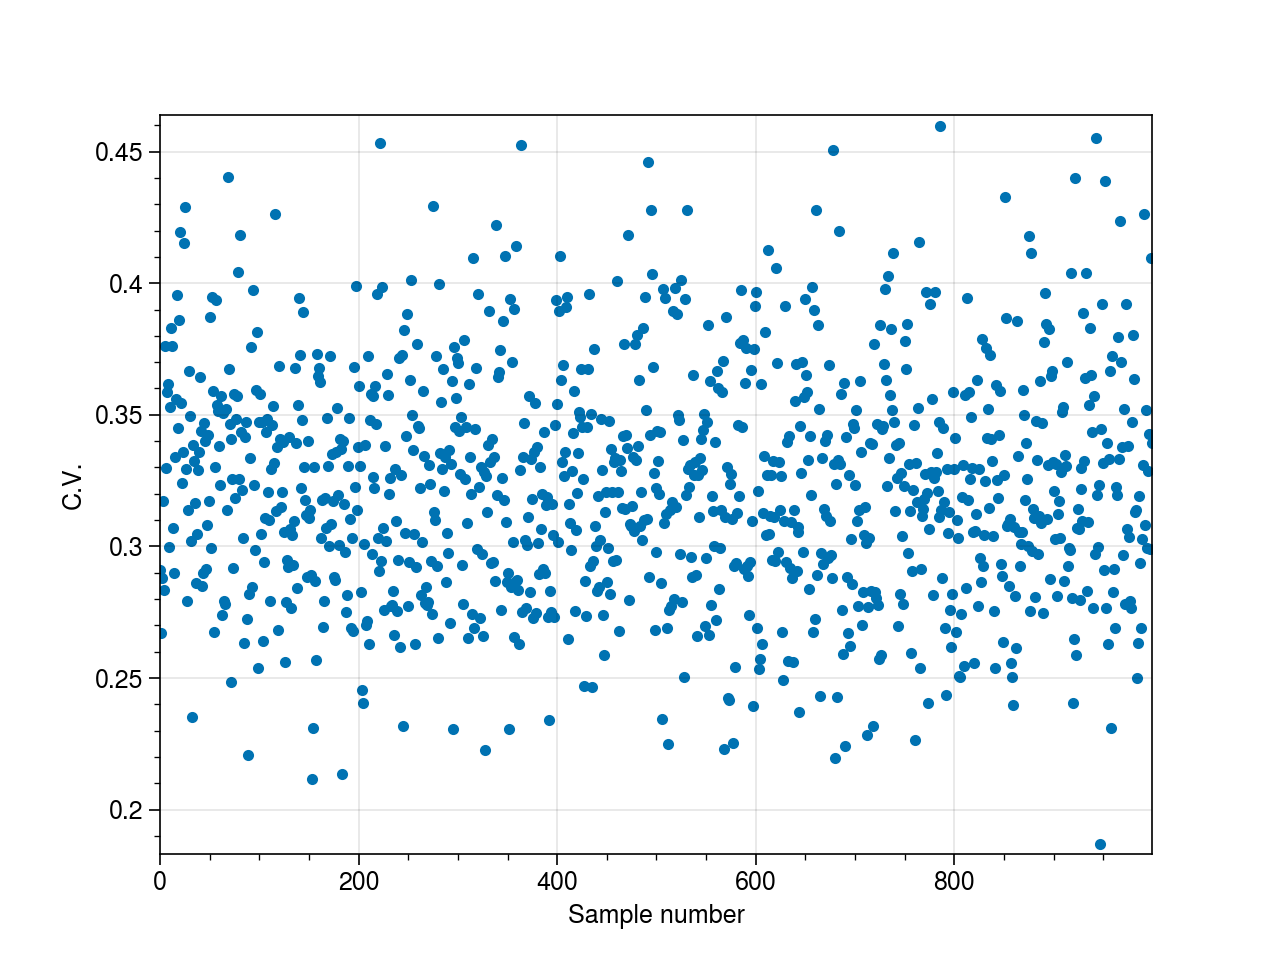

In [13]:
n = 1000
n_sample = len(emp_rf)

# Let's see how this works to get 33 samples from simulation data
samp_rf = pd.DataFrame(sims_rf).sample(n=n_sample)
#print(samp_rf)

# Get C.V.s of sampled simulation data
cvs = [pd.DataFrame(sims_rf).sample(n=n_sample).std()
       /pd.DataFrame(sims_rf).sample(n=n_sample).mean() for n in range(n)]

plt.xlabel('Sample number')
plt.ylabel('C.V.')
pd.DataFrame(cvs).describe()

plot_cvs(cvs=cvs)

Here are the statistics for all of the samples:

In [14]:
# Make a table comparing the CVs of the sampled values compared to the empirical
table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[sims_rf.mean(), emp_rf.mean()],
            'Standard Deviation':[sims_rf.std(), emp_rf.std()],
            'CV':[sims_rf.std()/sims_rf.mean(), emp_rf.std()/emp_rf.mean()],
            'No. in Sample':[len(sims_rf),
                       len(emp_rf)]})

table

,Source,Average,Standard Deviation,CV,No. in Sample
0,Simulations,446.751558,144.703117,0.323901,10000
1,Empirical,538.010606,215.004706,0.399629,33


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


33 33


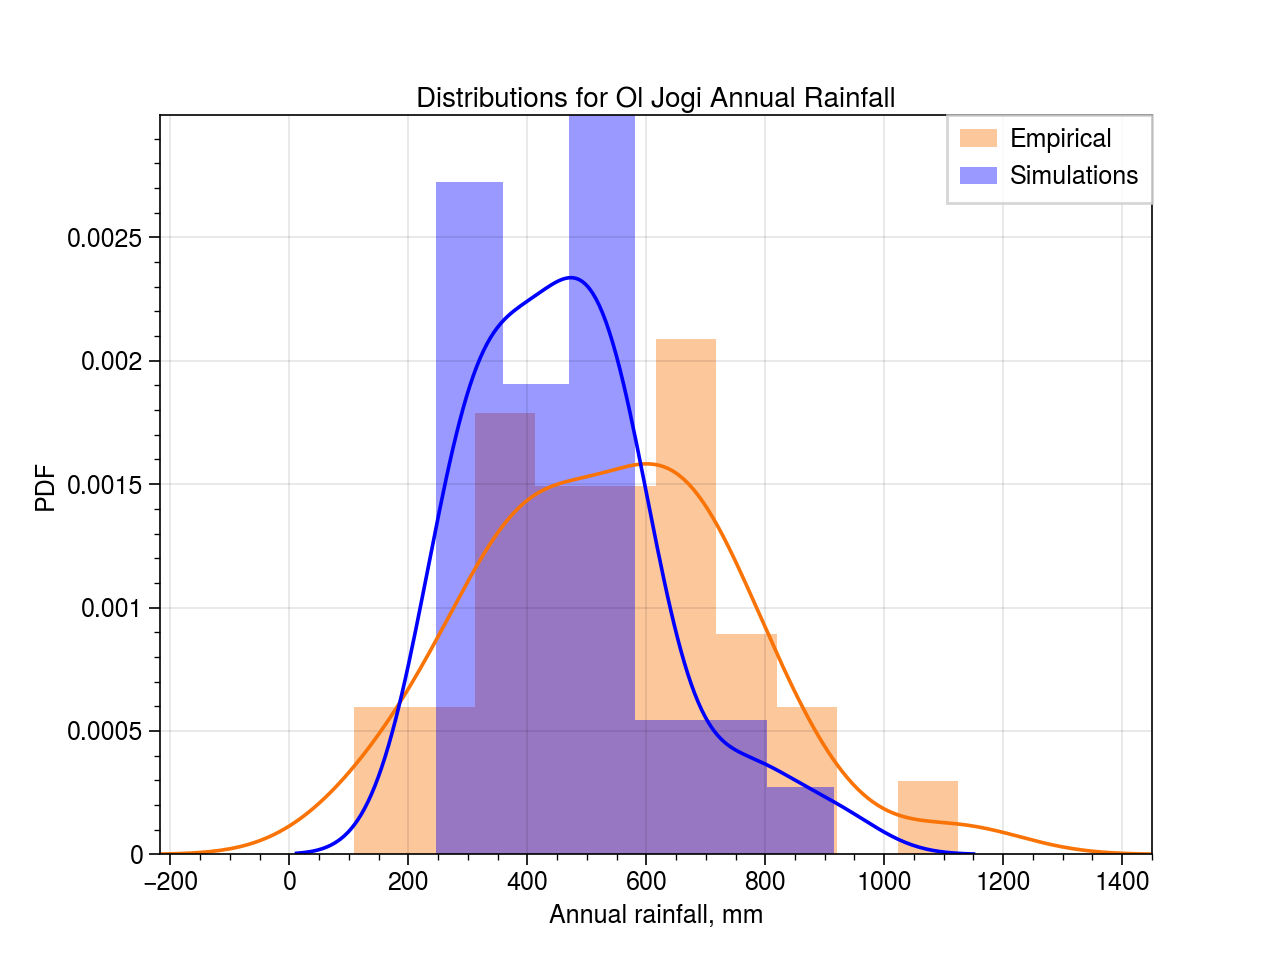

In [16]:
# Let's plot the sampled rainfall (from simulations) versus the empirical

# Get the n values
#sns.displot(samp_rf[0], label="Simulations") # "avg" # bw=.2
#sns.kdeplot(emp_rf, label="Empirical", cut=0) # clip=(0,1000
sns.distplot(emp_rf, label="Empirical", color='orange', bins=10)
sns.distplot(samp_rf[0], label="Simulations", color='blue')

plt.title('Distributions for Ol Jogi Annual Rainfall')
plt.ylabel('PDF')
plt.xlabel('Annual rainfall, mm')
plt.legend();

print(len(emp_rf), len(samp_rf[0]))